In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer

import re
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/qosquo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv('../data/processed/jokes.csv')
df.head()

,text,target
0,"Идет панихида. В зал вбегает взмокший человек,...",1
1,"Туземцы поймали мужика, уже привязывают на вер...",1
2,"– Алло, это психиатрическая больница?\n– Да.\n...",1
3,Жена дома заправляет водой все увлажнители воз...,0
4,Служащий – шефу:\n– Я работаю у вас на полстав...,1


In [7]:
df['target'].value_counts(normalize=True)

target
1    0.528746
0    0.471254
Name: proportion, dtype: float64

In [8]:
# check if 'text' has NaN values
df = df.dropna()
# get index of NaN values
df['text'].isna().sum()

np.int64(0)

In [9]:
from pymorphy3 import MorphAnalyzer
from razdel import tokenize
from nltk.corpus import stopwords
stopwords_ru = set(stopwords.words('russian'))
snowball = SnowballStemmer(language="russian")
morph = MorphAnalyzer()

def tokenize_text(text):
  # удаляем всякий мусор
  text = re.sub(r'<[^>]+>|https?://\S+|[\d]|[^а-яА-ЯёЁ\s]', ' ', text)
  # приводим к нижнему регистру
  text = text.lower()
  # токенизируем слова
  tokens = [token.text for token in tokenize(text)]
  # удалим стоп-слова и пунктуацию
  tokens_wo_punct = [token for token in tokens if token not in string.punctuation]
  tokens_wo_punct_stopwords = [token for token in tokens_wo_punct if token not in stopwords_ru]
  # лемматизируем текст
  clean_tokens = [morph.parse(token)[0].normal_form for token in tokens_wo_punct_stopwords]
  # clean_tokens = [snowball.stem(token) for token in tokens_wo_punct_stopwords]
  return clean_tokens

In [10]:
df['text_tokens'] = df.text.apply(tokenize_text)
df['text_processed'] = df.text_tokens.apply(lambda x: ' '.join(x))
df.head()

,text,target,text_tokens,text_processed
0,"Идет панихида. В зал вбегает взмокший человек,...",1,"[идти, панихида, зал, вбегать, взмокнуть, чело...",идти панихида зал вбегать взмокнуть человек по...
1,"Туземцы поймали мужика, уже привязывают на вер...",1,"[туземец, поймать, мужик, привязывать, вертеть...",туземец поймать мужик привязывать вертеть спра...
2,"– Алло, это психиатрическая больница?\n– Да.\n...",1,"[алло, это, психиатрический, больница, угнать,...",алло это психиатрический больница угнать машин...
3,Жена дома заправляет водой все увлажнители воз...,0,"[жена, дом, заправлять, вода, увлажнитель, воз...",жена дом заправлять вода увлажнитель воздух не...
4,Служащий – шефу:\n– Я работаю у вас на полстав...,1,"[служащий, шеф, работать, полставка, поэтому, ...",служащий шеф работать полставка поэтому просит...


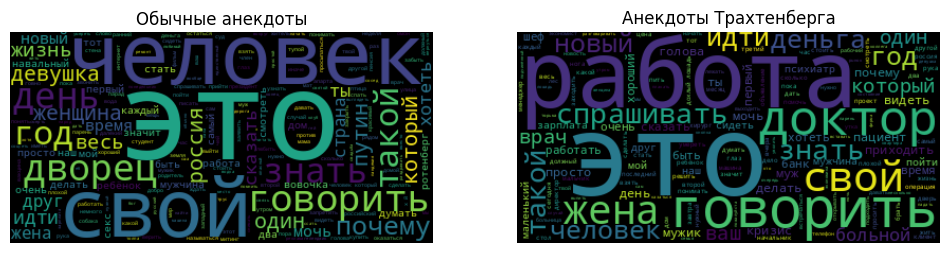

In [11]:
from wordcloud import WordCloud
text_0 = " ".join(df[df.target == 0].text_processed.values)
text_1 = " ".join(df[df.target == 1].text_processed.values)
wordcloud_0 = WordCloud().generate(text_0)
wordcloud_1 = WordCloud().generate(text_1)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('Обычные анекдоты')
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Анекдоты Трахтенберга')
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
# векторизация токенов с использование TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

X = tfidf.fit_transform(df.text_processed)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 42
# сравним распределение целевого признака
print(f"Train: {y_train.value_counts() / len(y_train)}")
print(f"Test: {y_test.value_counts() / len(y_test)}")

Train: target
1    0.529481
0    0.470519
Name: count, dtype: float64
Test: target
1    0.525822
0    0.474178
Name: count, dtype: float64


In [13]:
# обучем модель логистической регрессии
model = LogisticRegression(random_state=42, class_weight=None, solver='liblinear', max_iter=1000, C=1.0)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [14]:
y_pred = model.predict(X_test)

# метрики
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

print(y_test[:5])
model.predict_proba(X_test)[:5]

F1-score: 0.768
Confusion matrix:
[[59 42]
 [16 96]]
31     0
413    0
535    0
743    1
792    0
Name: target, dtype: int64


array([[0.48394908, 0.51605092],
       [0.59790523, 0.40209477],
       [0.50158464, 0.49841536],
       [0.38800646, 0.61199354],
       [0.5199621 , 0.4800379 ]])

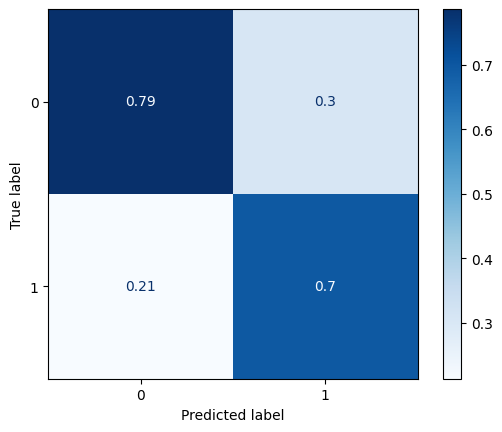

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
# матриц ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='pred')
plt.show()

Оптимальный порог: 0.5301


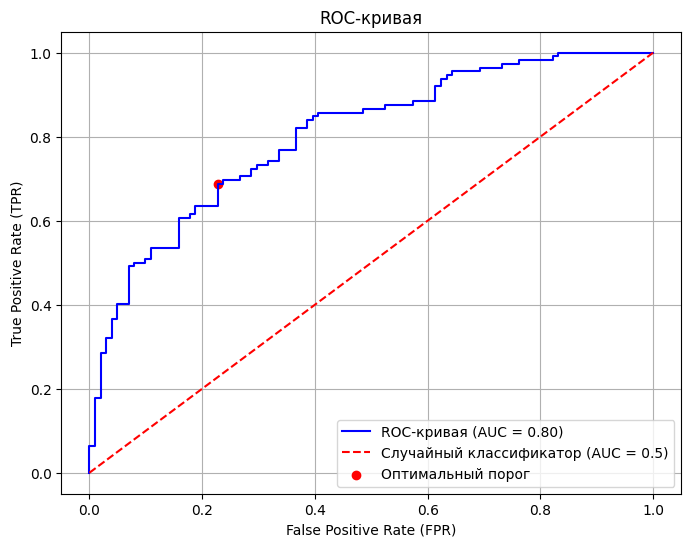

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Случайный классификатор (AUC = 0.5)')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Оптимальный порог')
print(f"Оптимальный порог: {optimal_threshold:.4f}")

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# подберем гиперпараметры
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 0.5, 1, 5, 10], 'class_weight': [None, 'balanced'], 'max_iter': [100, 1000, 10000]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 100}

In [18]:
# проверю на анекдоты, сгенерированном deepseek
new_text = """В трамвае едет старушка, рядом с ней стоит мальчик. Бабушка достает табакерку, берет понюшку и чихает.
— Будьте здоровы, бабушка! — говорит мальчик.
— Спасибо, внучек.
Бабушка опять берет табачку, делает понюшку и опять чихает.
— Будьте здоровы, бабушка! — опять говорит мальчик.
— Ну ты и глупый! Я же чихаю не потому, что болею, а потому, что табак нюхаю.
— Да вы, бабушка, хоть помет нюхайте, а пионер всегда должен быть вежливым!"""
new_text_clean = " ".join(tokenize_text(new_text))
X_new = tfidf.transform([new_text_clean])
model.predict_proba(X_new)[0][1]

np.float64(0.5421432889690023)

In [19]:
import joblib

joblib.dump(model, '../models/model.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

['../models/tfidf_vectorizer.pkl']